In [1]:
%load_ext lab_black

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Question 2: Fitting with censored data

In some experiments there are two kinds of measurements or data available: The usual ones, in which you get a number (say), and censored data, in which you don't get the specific number, but are told something about it, such as a lower bound. A classic example is a study of lifetimes of a set of subjects (say, laboratory mice). For those who have died by the end of data collection, we get the lifetime. For those who have not died by the end of data collection, we do not have the lifetime, but we do have a lower bound, i.e., the length of the study. These are the censored data values.

We wish to fit a set of data points,
$$
(x^{(1)},y^{(1)}), \ldots, (x^{(K)},y^{(K)}),
$$

with  $x^{(k)} \in \mathbf{R}^n$  and  $y^{(k)} \in \mathbf{R}^n$, with a linear model of the form $y \approx c^Tx$. The vector $c^{(k)} \in \mathbf{R}^n$ is the model parameter, which we want to choose. We will use a least-squares criterion, i.e., choose $c$ to minimize

$$
J = \sum_{k=1}^K \left(y^{(k)} - c^Tx^{(k)}\right)^2.
$$

Here is the tricky part: some of the values of  𝑦(𝑘)  are censored; for these entries, we have only a (given) lower bound. We will re-order the data so that $y^{(1)}, \ldots, y^{(M)}$ are given (i.e., uncensored), while $y^{(M+1)}, \ldots, y^{(K)}$ are all censored, i.e., unknown, but larger than $D$, a given number. All the values of $x^{(k)}$ are known.

Develop a method to how to find $c$ (the model parameter) and $y^{(M+1)}, \ldots, y^{(K)}$ (the censored data values) that minimize $J$. Carry out this method on the data values in `cens_fit_data_norng.m.`

The data file contains $c_\mathrm{true}$, the true value of $c$, in the vector `c_true`.

In [3]:
n = 20  # dimension of x's
M = 25  # number of non-censored data points
K = 100  # total number of points
c_true = np.array(
    eval(
        """
[-0.43, -1.7,  0.13,  0.29, -1.1,  1.2,  1.2, -0.038, 0.33, 0.17, -0.19, 0.73, -0.59, 2.2 , -0.14, 0.11, 1.1, 0.059, -0.096, -0.83]
"""
    )
)  # A little gross, but needed due to circumvent black formatting into huge vertical list

X = np.array(
    eval(
        """[[0.29, -1.6, 4.3e-05, 0.62, -1.2, 0.13, -0.33, 0.47, -0.46, 0.64, -1, 0.49, -0.54, 1.1, -0.9, 0.84, -0.65, -0.98, 1.1, -0.072, 1.4, -0.78, -0.89, -2.4, -1.4, 0.083, -0.57, -0.072, -0.026, 1.1, 2.1, -0.51, 0.72, -0.089, -0.37, 0.53, -0.027, -0.51, -0.61, 0.76, -1.4, 0.76, 0.2, -0.42, 0.44, -1.6, -0.85, -1, 0.49, 0.72, -0.15, 1.3, 0.66, -0.26, 1.7, -0.25, 0.26, 0.56, -0.8, -0.073, -0.3, 0.18, -0.67, -1.4, -0.76, 0.74, -0.33, -0.5, 0.045, 0.53, 0.81, -0.8, 0.25, 0.31, -2.1, 0.56, 0.54, 0.93, 1.4, 0.81, -0.4, -1.3, 0.14, -0.023, -1.3, -1.8, -1.7, -1.2, 0.8, -0.25, -0.3, -0.53, 0.87, 0.72, 0.87, 0.45, 0.91, 0.37, -2.3, -0.6], 
    [-1.3, 0.26, -0.32, 0.8, -2.2, 0.66, -0.84, -0.9, 0.37, -0.6, -0.18, -0.005, -1.3, -0.25, 0.14, -0.72, -1.1, -0.69, 2.4, 0.28, 1.3, -0.77, 0.14, -0.22, 0.61, 0.77, -1.5, -2.4, -1.1, 1.6, 0.08, 0.25, 0.039, -1, -0.83, 1, 0.17, 0.23, 0.69, -0.69, -0.69, -1.7, 0.26, -0.61, 0.57, 0.43, 0.35, -0.66, -0.87, 1.6, 0.32, 0.67, -1.6, -1.4, 0.12, -1.3, -0.19, 0.48, 0.31, -0.99, -0.17, 0.23, -0.9, -0.3, -0.6, 0.81, -2, 0.21, 2.4, 2.1, -1, -0.0083, -1.4, 1.4, -0.66, -2, 0.68, 1.2, 0.42, 1.9, 0.91, 1.2, -0.016, 0.11, -0.3, -1.5, 0.48, 0.3, 0.88, -0.15, 1.2, 0.54, -0.8, -0.28, 2.4, 0.89, 1.5, -0.55, 1.4, -0.99], 
    [0.71, -1.1, 1.1, 0.94, 0.99, -1.2, 0.5, 0.036, 0.73, 0.55, 1.5, -0.28, 1.1, -1.5, -0.14, -0.72, -0.048, 1.3, 0.23, 1.4, -0.91, -0.11, -0.24, 0.058, -1.3, 2.2, -0.05, -0.69, 0.75, 1.4, -0.94, 0.37, 1.5, 0.94, 0.29, -1.1, 0.88, -0.6, 0.02, 0.68, 0.33, 1.5, 2.1, 0.72, -0.69, -0.74, 0.11, 0.56, 0.08, -2.1, 1.3, -0.28, -3, -1.3, 0.65, 1.2, -0.079, -0.68, 1.1, -0.75, 0.18, -1.2, -0.15, -0.57, 0.81, -0.14, 1.6, 0.75, -0.31, 0.35, 1.3, 0.63, 0.97, 0.33, 1.5, -0.76, -0.59, -0.25, 0.069, 0.4, -0.14, 1.5, -0.94, 0.81, -2.6, 0.82, -0.45, -0.73, -0.22, -1.2, 1, 0.68, -0.75, -1.4, 0.11, 1.1, -1.1, 0.58, 1.4, 1.2], 
    [1.6, 1.4, -1.9, -0.99, -0.52, -0.46, 1.5, -0.63, 2.1, -1.1, -0.038, 1.3, -0.71, 0.0097, -1.2, -0.2, 0.38, -0.91, -0.27, 0.18, -2.3, -0.98, -0.075, -0.42, -0.66, 0.33, 0.55, -1.4, 0.5, -0.76, 0.64, 0.18, -1.7, -1.1, -1.8, 0.36, 0.18, 0.021, 1.1, -1.1, -1, -1.6, -2.3, 0.34, 0.83, 0.56, -1.1, -1.2, -0.52, -0.74, -2.2, -0.023, 0.54, -0.89, 2.1, 1.5, 0.7, 0.28, -1.7, -0.031, 0.42, 0.7, 0.95, -0.12, 0.07, -0.1, 0.23, -0.95, 0.19, 0.23, 0.015, 0.15, 1.6, 0.48, -0.33, -2.4, -0.26, -0.71, 0.29, -0.86, 1.3, 1.8, -1.5, -1, 0.78, -0.23, 0.39, -1.1, 0.3, -0.022, 2.1, 0.54, -0.75, 0.46, 0.026, -0.1, 1.8, -2, -0.45, 2.4], 
    [-0.69, -0.81, 0.43, 0.21, 0.33, -0.26, -0.55, 0.54, -1.4, 0.086, 1.2, 1.9, -0.011, 0.071, 1.2, -0.02, -0.33, -0.41, 0.7, -0.54, 1.8, -0.96, -0.36, -0.2, -0.15, 0.86, 0.083, 0.33, -0.52, 0.44, 1.7, -0.037, -1, -0.71, -1.6, -0.037, 0.76, 0.42, -1.3, 0.9, 0.29, 1.1, 0.34, 0.88, -2.2, -1.4, -0.68, -0.78, -1.4, 0.18, 1.3, -0.91, -1, 0.59, -0.34, 0.24, -0.8, -1.3, -1.1, 0.99, 1.7, 0.43, 1.6, -0.39, -1.8, -0.8, 0.65, 0.61, 0.95, 1.3, 0.22, 2.6, -1.4, 0.4, 2.7, -0.66, 1.5, -0.59, 0.47, 2.4, 0.32, 0.63, 0.36, -1, 0.6, -1.6, 0.053, -1.4, -0.52, 0.62, -0.66, -0.51, -0.31, 1.1, 0.97, 1.5, 0.15, 0.52, -0.63, 2.3], 
    [0.86, 0.53, 0.9, 0.24, 0.23, -1.2, -0.85, 0.55, -1, -2, -0.7, -0.52, -0.00082, 0.32, -0.015, 0.28, -0.5, -0.51, -0.49, 1.6, 0.39, -2.4, -2.1, -1.5, 0.25, 0.68, 1.6, 0.6, -0.56, 0.91, 0.59, -1.6, -0.76, -1.2, 2, -1.2, 0.51, 1.2, 0.48, -2.1, 1.1, -1.1, 0.29, 0.28, 1.1, 0.46, -0.28, 0.27, -0.38, 0.53, -0.38, -1, 0.91, 1.8, 0.73, -1.4, -0.8, -0.72, -0.19, -0.6, 2, 1.5, 0.43, -0.84, 1.8, 0.49, -1.1, 1.8, -0.53, -0.013, 1.7, -1.3, -1.5, -0.073, -1.6, -0.11, 1, -0.26, 1.8, -0.84, -0.48, 0.083, 0.48, 0.28, 0.94, -0.32, -0.49, -0.59, -0.16, 1.9, -1.1, -1.3, -1.5, -1, -0.0053, 0.17, -0.28, 1.6, 1, 2.3], 
    [1.3, 0.22, 0.73, -1, 0.021, -1.3, -0.25, -0.2, 1, -0.49, 0.0075, 0.1, -0.25, 0.5, 0.54, 1.1, -0.036, 1.6, 1.9, 0.83, 0.02, -0.84, -0.14, -1.1, -0.077, 0.55, -0.33, 0.15, -0.75, -1.1, 0.79, 0.34, 2.2, 1.1, -0.072, -0.28, 0.13, 0.77, -1.6, 0.28, 0.24, 0.39, 0.66, -0.15, -0.0016, 0.63, 0.65, 1.5, -0.46, -0.55, 0.0025, 0.37, 1.6, 1.3, 0.29, 0.66, -0.0076, -0.66, 0.46, 1.5, 0.7, -0.51, -0.56, -1.7, 0.65, 1.2, 0.2, 0.089, -1.1, -1.3, -2.1, 1, -0.075, 1.3, -0.54, 0.3, 0.3, 1.2, 0.26, 0.28, 0.076, 2.1, 0.32, 0.29, -1, -0.8, 0.24, 0.52, -0.098, 0.082, 0.95, -0.61, 0.83, -2.8, 1.4, 0.8, 1.7, 0.73, -0.49, -0.27], 
    [-1.6, -0.92, 0.58, -0.74, -1, 0.93, 0.66, -2.1, -0.39, 0.46, -0.78, -0.81, 0.4, 1.3, -0.72, 0.62, -0.17, 0.081, 1.1, 0.23, -0.41, 0.26, 1.4, -0.82, 1.7, 1, 0.8, -0.1, 0.93, 0.2, 0.11, -0.13, 0.43, -0.68, 2.6, -0.16, 0.28, -2.6, -1.4, -0.73, 0.16, 0.97, -0.58, -0.09, -1.6, 0.38, -1.2, -1.1, -0.29, 0.3, 0.88, 0.9, -0.98, -0.49, -0.85, -2.6, -0.73, 0.2, -0.92, -0.81, -1.4, -0.0067, 0.18, -0.45, -1.5, 1.3, 1.7, 2.6, -1.6, -0.56, 0.11, 0.78, 0.081, 0.98, 0.55, -0.58, -0.82, -1.5, 1.5, 0.82, -0.11, 1.3, -1.9, -0.25, -0.068, 0.69, 0.72, -1.5, 1, 1.6, -0.4, -0.57, -0.61, 1, 1.8, -1.7, 0.67, 0.56, -0.4, 0.5], 
    [-1.4, -2.2, 0.04, 1.1, -0.95, 0.011, -0.85, 0.13, -1.4, -0.32, 0.59, 0.68, -0.26, -0.55, -0.66, -1.8, -0.96, -1.1, -1.2, 0.67, -1.5, -0.18, 0.65, 0.37, 1.6, 1.3, -0.78, -2.6, -0.25, 0.76, -0.16, 0.49, -0.44, -1.7, -0.24, -1.1, -0.98, 0.29, 0.29, -0.77, 0.41, 0.82, 0.89, 0.29, -1.2, -1, -0.6, 0.63, -0.3, -1.2, 0.58, 1.3, 1, -2.2, -2.5, -0.53, -1.5, -1.8, -0.65, 0.65, 0.36, -0.53, -0.77, -1.5, -0.38, -0.28, 0.73, -0.68, 1.2, 0.76, -1.1, -0.83, -0.84, 1.7, 1.5, -3.1, -0.49, -0.39, 0.32, 1.2, 1.4, -1.8, 0.68, -0.22, 0.082, -0.042, 0.15, -0.087, 0.43, -0.38, -0.38, 0.086, 0.96, 0.077, 0.89, 0.17, -0.35, -0.81, 1.4, -0.12], 
    [0.57, -0.059, 0.68, -0.13, -0.37, -0.65, -1.2, 1.6, 0.32, 1.2, -0.25, -2.4, -1.7, 0.26, 0.31, 0.7, 1.3, -1.1, -0.67, -0.51, 0.22, -0.17, -0.38, -0.59, 0.63, 0.044, -1.3, 0.028, -0.15, -1.3, 0.87, 0.6, 0.03, 0.81, 0.17, -2, -0.94, 0.83, -0.14, 0.15, 1.2, 0.037, 0.17, 1.2, 0.21, -0.35, -0.48, -0.8, -1.6, -0.19, -1.6, -0.13, 0.16, 0.24, -2.4, 3.2, 0.87, -1.4, 0.62, -1.3, -0.57, 0.72, -0.94, -0.096, 0.21, 0.22, 0.79, 2.8, 0.49, -0.91, -1.6, -0.59, -0.56, -0.41, -0.46, 1.6, 0.87, 0.28, 0.8, -0.064, 0.71, -0.014, 0.23, 0.9, -1.8, 0.32, 0.13, -0.013, -0.026, -1.3, 0.48, 0.69, 2, -1.9, 1.1, -0.48, -0.26, -0.54, 0.28, -0.0019], 
    [-0.4, -1, 0.57, 0.39, -1.2, 0.81, -0.12, 1, 1.6, -0.63, 0.48, 0.99, -1, -0.013, 0.11, 0.81, 0.44, 1.7, 1.3, 0.86, -1.4, -0.12, -0.66, 1.5, 0.092, -0.31, 0.67, -0.88, -1.3, -0.95, -0.19, -0.086, -0.32, 1.4, 0.92, -0.91, -0.013, -0.0081, -1.1, -0.34, 1.4, -0.93, 0.85, 0.81, 0.22, 0.44, 0.98, -0.31, 1.1, -0.3, -1.5, 0.61, -0.59, -0.74, -0.35, 0.44, -0.27, 0.2, -1.3, -0.87, -1, 1.1, -1.4, 0.91, -0.77, 0.63, 0.6, -0.017, 1.6, 1.4, 0.64, 0.066, -0.028, 0.57, -0.5, -0.41, 0.36, 0.83, 0.58, 0.65, 0.37, 2.5, 1.2, -0.64, -1.8, 0.51, -1, -0.35, -0.38, -0.72, 0.44, 2.1, 0.29, -0.61, 0.4, -0.73, -0.64, 1.3, 1.9, -0.43], 
    [0.69, 0.61, -0.26, 0.088, -1.1, 0.23, -0.065, -1.6, 0.71, -2.3, 0.67, 0.22, 0.24, -0.58, 1.8, 0.64, 1.3, 1.9, 0.39, 0.27, -0.84, 0.17, 0.25, 0.14, -0.81, 0.23, -1.4, -0.27, 0.31, 0.78, 0.075, 0.33, 0.98, 0.67, -0.18, -0.0056, 0.35, 0.86, -0.29, 0.97, -1, -0.11, 0.96, -1.4, -1, -1.6, 1.8, -0.6, 1.3, 0.96, 0.57, 2, 1.6, -1.8, -0.61, -1.1, -1.6, 1.5, 1, -0.47, 0.7, 0.5, -1.9, 2.4, -0.11, -0.55, -0.058, 0.27, -0.45, 0.25, -0.4, -0.012, -1.2, 0.74, 1.2, 1.4, -0.08, -0.98, 1.8, -1.8, -0.6, -0.67, 0.13, -0.18, -0.66, -1, 1.3, 0.99, -0.24, -0.56, 0.38, -0.0029, -0.39, 1.2, 0.19, -2.1, -0.91, -0.48, -0.8, -0.19], 
    [0.82, 0.51, -0.38, -0.64, 1.5, -0.99, 0.49, -0.079, 2, -1.2, -0.078, 0.26, -1.3, 2.1, -0.28, 1.3, -0.5, 1.6, 0.39, 0.62, -0.21, -0.5, -0.38, -1.9, -0.46, 1, -1.3, -0.33, 2.7, -0.0063, -0.53, -0.34, 0.018, 0.14, -0.52, -1.7, -0.89, 0.77, -0.58, -0.11, 0.21, -0.8, 1.3, 0.12, -0.45, -0.7, 1.4, 1.3, -0.13, -0.53, -0.91, 2.3, -0.52, 0.45, -0.41, 0.89, -0.39, 0.37, 0.86, 0.22, 0.48, 2.8, -0.065, 0.52, 0.34, 0.23, -1.1, -0.91, 1, 0.12, -0.4, -0.077, 0.73, 0.22, 0.041, -1.4, 0.75, -0.1, -0.94, 0.06, -0.85, 0.26, 0.18, 0.72, 1.4, 0.099, 1.2, 0.64, -1.2, 0.62, 1.1, -0.09, 0.58, -0.58, -0.69, -1.8, 0.72, -1.8, -0.56, 0.99], 
    [0.71, 1.7, -0.3, -0.56, 0.056, 1.3, -0.6, -0.68, 0.5, 1.1, 0.89, 1.2, -0.35, -0.26, 2.2, 0.33, -1.1, -1.3, -1.7, -1, 0.76, -0.71, -0.53, -0.45, -1.4, 1.2, -0.61, -1.2, 0.29, 0.52, -0.69, -0.32, 0.82, -0.86, 1.4, 1.3, 0.81, 1.3, -0.9, 1, 0.59, -1.7, -0.064, -0.22, 1.4, -1.1, 0.91, 0.86, -0.74, -0.9, -1.6, -0.37, 1.2, 0.58, -1.4, -0.28, -0.14, -0.44, -0.64, 1.9, -0.19, -0.16, 0.67, 0.41, 1, 0.36, 2.1, -2, 2, 0.38, 0.084, -1.6, 0.06, 1.3, 0.75, 0.9, -1.8, 0.13, -0.92, -0.76, 0.66, -0.37, -0.61, 0.3, 2.1, -0.12, -2.6, 2.9, 0.76, -1.3, 0.86, -0.25, -1.1, -0.26, 0.011, -0.052, -0.0073, -0.93, 1.7, 0.47], 
    [1.3, 0.59, -1.5, 0.44, -1.2, 0.29, -0.15, -1, 1.9, -0.11, 2.3, -0.27, -0.94, -1.4, 1.5, -0.67, 0.81, -0.21, 0.23, 1.5, 0.38, 0.51, 0.055, -0.65, -0.37, -0.54, -1.5, 0.58, -1.4, 1.4, -0.27, -0.38, 0.7, -0.75, -0.87, -0.6, 0.11, 1.2, 0.25, -0.48, -0.26, -0.9, 1.3, 0.57, -0.46, 1, 0.33, -2.1, 0.21, -0.89, -0.36, 2.2, 1.6, 0.86, 0.23, 1, -2.3, -0.049, 0.66, 0.11, -0.38, 0.43, 0.21, 1.1, -1.4, 0.52, -1.4, -0.32, 0.6, -0.07, -0.44, 1.7, 0.15, 0.63, 1.2, 0.54, 1.2, 0.063, 0.38, -1.7, 1.5, 1.3, -1, 1.5, 0.17, 0.69, -2.1, -1.2, 1.2, -0.12, -1.2, -0.87, 0.061, 0.0047, -1.1, -0.086, -2.8, 0.92, -0.64, -1.4], 
    [0.67, -0.64, -0.23, -0.95, -0.041, 1.5, -0.43, -1.2, -0.34, 0.38, 0.52, -0.13, -1.2, 1.8, -1.9, -0.15, 0.041, -0.2, 0.69, 0.43, -1.3, -0.42, 1.3, 0.1, -0.47, 0.91, 0.56, 0.24, 0.25, 0.48, -1.2, -0.95, -0.23, 1.2, 0.81, -2.1, 2.7, 0.96, -1.5, 0.069, 2.5, 0.59, 0.23, -0.3, 0.033, 1.7, 0.07, -0.36, -0.4, 0.28, -0.4, -0.16, -2.1, -0.27, 0.21, -0.36, -1.4, 0.078, 1.3, -0.41, -0.89, -2, -0.0081, 0.43, -1, -0.62, 0.46, 0.59, 0.018, -0.58, -0.56, -0.47, 1.6, -1.1, 0.3, -0.47, -0.061, 0.37, 0.91, 1.1, -0.81, -0.65, -0.3, -0.044, -1.7, 1.9, 0.39, 0.16, -1, -1.1, 0.4, 0.42, 0.012, -0.039, 1.9, -1.2, -0.15, 0.041, -1.4, 0.27], 
    [1.2, 0.38, 0.12, 0.78, -1.1, 1.1, -0.079, 0.29, -1.1, 0.94, -0.012, -1.3, -1, 0.33, -1.7, -2.4, -0.76, 0.31, -0.64, -1.9, 1.5, 0.23, -2.5, -0.22, 1.8, -0.17, -0.28, -0.35, -1.4, -0.79, 0.25, 0.23, -0.11, 1.2, -0.51, 0.11, 0.41, -1.7, 0.31, 0.4, 0.86, 0.55, -1.4, 1.1, 0.8, 0.71, -1.5, 0.55, 0.065, -0.75, -1.2, -0.7, 2.9, -0.42, -0.72, 1.3, -1.8, 2, 0.31, 0.51, -1.8, -0.55, 0.02, 1.3, -0.64, 1.3, 0.39, 0.83, -1.6, 0.47, 0.88, 0.095, -0.78, -0.45, 1.1, 2.4, -0.39, -0.1, 0.15, 1.5, -1.3, 0.062, 1.5, -0.03, 0.28, 0.33, -0.86, 0.79, 1.7, -2.8, -0.58, -0.13, -0.17, -0.51, -0.17, -0.75, 0.58, 0.41, -0.76, 2.6], 
    [-1.2, -1, 0.31, 0.57, -1.3, -0.68, 1.5, -0.43, -0.21, -2.1, 0.91, -1.7, -0.4, -1.1, -0.57, 0.47, -0.089, -0.57, -1, 0.47, 0.033, -0.96, 0.58, -0.28, 0.75, -0.34, -1.3, 0.89, 0.15, 0.75, 0.1, 1.2, 0.13, -0.61, 0.74, 1.5, -1.3, -0.99, -2, 1.1, -0.85, -0.42, -0.15, -0.18, 0.9, -0.75, -0.42, -1.6, -1.8, 1.6, -1.1, 0.56, 1.4, -0.21, 0.76, 1, 1.1, -0.073, 0.86, -1.2, -1.6, -1.9, -0.56, -0.19, 0.17, 0.97, 2.1, -1.7, 1.2, 1.3, -0.81, 0.29, 1.6, -0.73, 0.77, 2, 0.61, -0.7, -0.2, 0.24, 1.7, -0.74, 1.8, -0.38, 0.39, -0.095, -1.2, -0.58, -0.49, 0.25, -0.98, 0.54, -0.69, -1.2, -0.73, 0.95, 0.75, 0.6, 0.16, -0.054], 
    [-0.02, -0.02, 1.4, -0.82, -0.26, -1.3, -0.61, 0.056, 1.2, -0.64, 0.056, -0.7, 0.17, 0.62, -0.19, 0.12, -2, -0.98, -0.19, 1.3, 1.9, -0.15, -1, -0.73, 0.065, 0.54, -0.89, 1.6, -1.7, -0.17, -0.041, -0.58, -0.8, 0.81, 0.85, 0.053, 0.38, 0.69, 0.53, 0.62, 0.81, 0.062, -0.5, -1.5, 0.14, 0.23, -0.021, -0.21, 1.7, 0.57, 0.29, -0.05, 1.1, -0.17, -1.6, 0.21, -0.14, 0.94, 0.13, -0.096, -1.2, -0.11, 1.9, 0.13, 1.3, -2.4, -0.32, -1.9, 0.68, 1.6, -0.26, 0.92, 1.1, 0.35, -1.3, 0.8, 0.64, -0.39, 1.5, -1.1, 0.1, -0.18, -1.3, -0.55, -0.099, 0.031, 2.6, 0.53, 0.17, -0.86, 0.12, 0.88, -0.99, 0.71, -0.99, -0.18, -0.17, 1.9, 0.38, 0.47], 
    [-0.16, -0.048, -0.35, -0.27, 0.95, -0.073, -1.3, -0.37, -1.1, -0.7, -1.1, 0.28, -0.12, 1.3, 0.0089, -0.59, 1.1, -0.45, -1.1, 0.64, -1.2, 0.74, 0.94, -0.065, -0.29, 0.93, -0.99, -1.1, 0.72, -0.82, -2.2, -0.5, -0.24, 0.22, -0.83, 0.16, 0.5, -0.97, 0.34, -0.29, 0.7, 0.46, -1.7, 1.4, -1.6, -0.22, 0.23, -0.43, 0.33, 0.32, -1.9, 1.2, -0.77, 0.22, -1.1, -0.3, 1.1, -0.08, 0.017, 0.45, -0.42, -1.3, -0.22, -0.66, 1.9, -1.1, 1.5, -0.44, -0.78, -0.7, 0.49, 0.51, -0.17, -0.51, -0.51, 0.031, 1, 0.016, -0.62, 2.4, -0.8, 1.1, 0.39, 0.93, 0.18, -0.61, -0.9, 1.7, 0.35, 1.1, 0.068, -1.3, -0.05, 0.73, 0.89, -0.066, -0.58, 0.71, 0.18, -2.1]]
"""
    )
).T

y = X @ c_true + 0.1 * np.sqrt(n) * np.array(
    eval(
        "[-0.8,-0.46,0.19,0.89,-1.6,-0.32,-0.7,-0.74,0.37,1.4,0.46,0.66,1.1,0.98,-1.3,-0.023,0.13,2.4,0.9,0.076,0.36,-2.1,-2.3,-0.37,1.3,0.56,-0.18,-0.036,1.9,1.3,-0.36,-0.33,0.083,0.43,-1.2,-2.7,-0.54,2.2,-0.61,1.4,1.2,0.74,-0.12,-0.031,-1,-1,0.63,0.87,2.1,-0.59,0.59,1.5,2.1,-0.75,-1.5,-0.21,0.49,-0.32,0.82,-1.4,1.1,0.98,0.49,1.3,0.59,0.45,-1.4,-0.92,-1.4,-1.5,0.097,-0.23,-0.32,0.63,0.039,-0.016,0.45,-0.52,-1.1,-0.048,-0.5,1.6,-0.24,-0.96,-0.15,1.7,1.6,-1.1,0.097,0.25,2.2,0.31,2,-0.12,-0.27,1.4,-0.074,-0.36,-0.78,-0.25]"
    )
)

# Reorder measurements, then censor
sort_ind = np.argsort(y)
y = y[sort_ind]
X = X[sort_ind, :]
D = (y[M - 1] + y[M]) / 2
y = y[:M]

Give the value of the residual

$$
\frac{\| c_\mathrm{true} - \hat c\|_2} {\| c_\mathrm{true}\|_2}
$$
where $\hat c$ is the value of $c$ found using your method:

In [4]:
c_hat = cp.Variable(n)
y_hat = cp.Variable(K - M)
constraints = [y_hat >= D]
obj = cp.Minimize(
    cp.sum_squares(y - X[:M, :] @ c_hat) + cp.sum_squares(y_hat - X[M:, :] @ c_hat)
)
prob = cp.Problem(obj, constraints)

In [5]:
# X.shape, c_hat.shape, y_hat.shape, K - M, y.shape

In [6]:
prob.solve()

2.906876415923428

In [7]:
residual = np.linalg.norm(c_true - c_hat.value) / np.linalg.norm(c_true)
residual

0.17521758003435312

Give the value of the residual

$$
\frac{\| c_\mathrm{true} - \hat c_\mathrm{ls}\|_2} {\| c_\mathrm{true}\|_2},
$$

where $\hat c$ ls  is the least-squares estimate of $c$ obtained by simply ignoring the censored data samples, i.e., the least-squares estimate based on the data 

$$
(x^{(1)},y^{(1)}), \ldots, (x^{(M)},y^{(M)})
$$


In [8]:
c_hat_ls = cp.Variable(n)
obj_ls = cp.Minimize(cp.sum_squares(y - X[:M, :] @ c_hat_ls))
prob_ls = cp.Problem(obj_ls)

In [9]:
prob_ls.solve()

1.104722870116608

In [10]:
residual_ls = np.linalg.norm(c_true - c_hat_ls.value) / np.linalg.norm(c_true)
residual_ls

0.36584596178950674

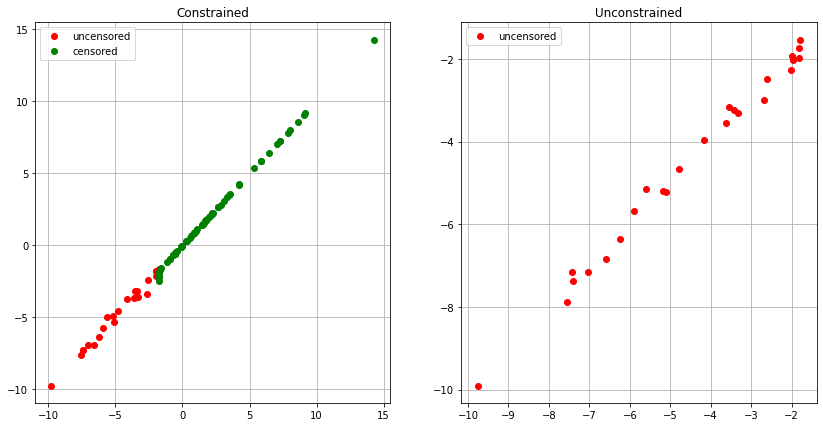

In [11]:
# Compare fits
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax = axes[0]
ax.plot(y, X[:M, :] @ c_hat.value, "ro", label="uncensored")
ax.plot(y_hat.value, X[M:, :] @ c_hat.value, "go", label="censored")
ax.set_title("Constrained")

ax = axes[1]
ax.plot(y, X[:M, :] @ c_hat_ls.value, "ro", label="uncensored")
ax.set_title("Unconstrained")

for ax in axes:
    ax.grid()
    ax.legend()

## Question 3: Minimax rational fit to the exponential
See exercise 6.9 of Convex Optimization for background. Here, we consider the specific problem instance with data

$$
t_i=-3+6(i-1)/(k-1), \quad y_i = e^{t_i}, \quad i=1,\ldots, k, 
$$
where  $k=201$ . (In other words, the data are obtained by uniformly sampling the exponential function over the interval $[−3,3]$.) Find a function of the form

$$
f(t)=\frac{a_0+ a_1 t + a_2 t^2 }{1+ b_1 t+ b_2 t^2}
$$

that minimizes $\max_{i=1,\ldots,k} | f(t_i)-y_i |$. (We require that $1+b_1 t_i+ b_2 t_i^2 > 0$ for $i=1, \ldots, k$.)

Find optimal values of $a_0, a_1, a_2, b_1, b_2$, and give the optimal objective value, computed to an accuracy of 0.001.

Hint: You can use `strcmp(cvx_status,'Solved')` after cvx_end to check if a feasibility problem is feasible.

In [12]:
import patsy

In [13]:
# Problem is quasi-convex, so it can be solved with "Algorithm 4.1 Bisection method for quasiconvex optimization."
k = 201
i = np.arange(1, k + 1)
t = -3 + 6 * (i - 1) / (k - 1)
t2 = t * t
y = np.exp(t)

In [14]:
_, X = patsy.dmatrices("y ~ t+ I(t**2)", data={"t": t}, return_type="matrix")

In [15]:
X = np.array(X)

In [16]:
a = cp.Variable(3)
b = cp.Variable(2)
c = cp.Parameter(nonneg=True)

p = X @ a
q = X[:, 0] + X[:, 1:] @ b
constraints = [
    q >= 0,
    cp.abs(p - cp.multiply(y, q)) <= cp.multiply(c, q),
]
obj = cp.Minimize(0)
prob = cp.Problem(obj, constraints)

In [17]:
lower, upper = 0, np.exp(3)
accuracy = 0.001
solver = "GLPK"  # ECOS and CVXOPT failed on last iteration
gamma = upper

while upper - lower > accuracy:
    c.value = gamma
    try:
        prob.solve(solver=solver)
    except cp.SolverError:
        prob.solve(solver=solver, verbose=True)
    if prob.status == "infeasible":
        lower = gamma
    elif prob.status == "optimal":
        upper = gamma
        a_value = a.value
        b_value = b.value
    else:
        raise ValueError
    gamma = (upper + lower) / 2
    print(prob.status, f"{gamma:0.4f}, {upper-lower:0.3f}")

optimal 10.0428, 20.086
optimal 5.0214, 10.043
optimal 2.5107, 5.021
optimal 1.2553, 2.511
optimal 0.6277, 1.255
optimal 0.3138, 0.628
optimal 0.1569, 0.314
optimal 0.0785, 0.157
optimal 0.0392, 0.078
optimal 0.0196, 0.039
infeasible 0.0294, 0.020
optimal 0.0245, 0.010
optimal 0.0221, 0.005
infeasible 0.0233, 0.002
optimal 0.0227, 0.001
infeasible 0.0230, 0.001


In [18]:
print(f"a={a_value}, b={b_value}, optimal value={gamma}")

a=[1.0094712  0.61371231 0.11414574], b=[-0.41397782  0.04835865], optimal value=0.022986072833848195


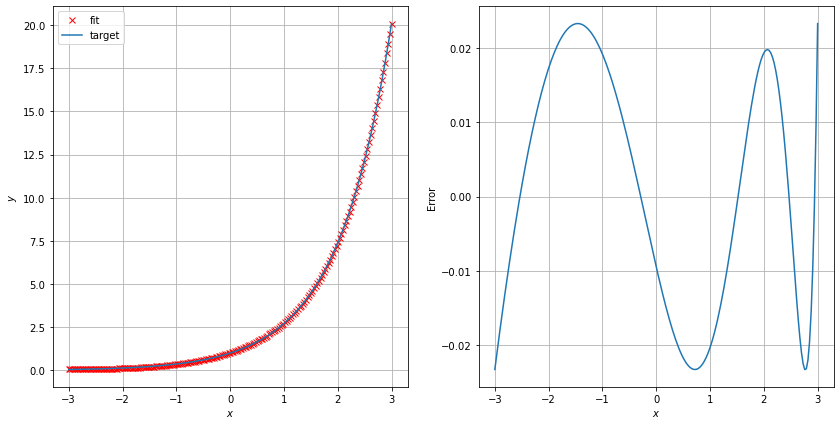

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

fitted = X @ a_value / (X[:, 0] + X[:, 1:] @ b_value)
ax = axes[0]
ax.plot(t, fitted, "rx", mfc="none", label="fit")
ax.plot(t, y, label="target")
ax.set_ylabel("$y$")
ax.set_xlabel("$x$")
ax.legend()

ax = axes[1]
ax.plot(t, y - fitted)
ax.set_ylabel("Error")
ax.set_xlabel("$x$")

for ax in axes:
    ax.grid()